In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

np.random.seed(2)

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [4]:
# Extract labels from train to get yTrain and leave the rest of train as xTrain
yTrain = train["label"]
xTrain = train.drop(labels=["label"], axis=1) # train is a dataframe and were are dropping along the y axis
del train
print("xTrain shape:", xTrain.shape)
print("yTrain shape:", yTrain.shape)

xTrain shape: (42000, 784)
yTrain shape: (42000,)


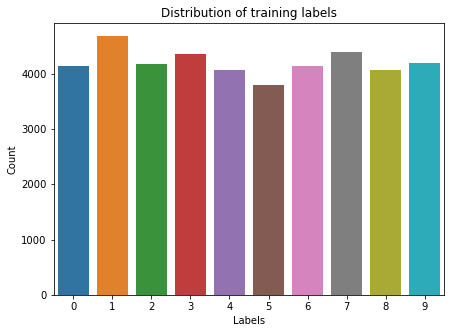

In [5]:
# Visualize the distribution of labels in yTrain
plt.figure(figsize = (7, 5))
ax = sns.countplot(yTrain)
ax.set(xlabel="Labels", ylabel="Count")
plt.title("Distribution of training labels")
plt.show()

In [6]:
# Check for null labels
print("Any null value in training labels:", yTrain.isnull().any())

Any null value in training labels: False


In [7]:
#So there are no missing values
#Normalize and reshape for CNN
xTrain = xTrain/255.0
test = test/255.0

In [8]:
#Reshape to get (28, 28) images. Thus, reshape to (-1, 28, 28, 1), where -1 is to keep the total number od pixels same
xTrain = xTrain.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [9]:
#One-hot encoding 
yTrain = to_categorical(yTrain, num_classes=10)
print("yTrain in one-hot encoding:", yTrain.shape)

yTrain in one-hot encoding: (42000, 10)


In [10]:
seed = 2 # To split at random (Dataset is balanced as visualized from the countplot)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.1, random_state = seed)
print("Training set instancess:", yTrain.shape[0])
print("Validation set instances:", yVal.shape[0])

Training set instancess: 37800
Validation set instances: 4200


In [11]:
#Model using CNN
model =Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same', input_shape=(28,28,1), strides=1))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='Same', strides=1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='Same', strides=1))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='Same', strides=1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10, activation='softmax'))

In [12]:
#Using Andam optimizer and annealing lr for better accuracy and speed
lr_anneal = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
optimizer = opt.Adam(lr = 1e-3)

In [13]:
#Using categorical_crossentropy loss
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
#Train for 30 epochs with a batch_size of 100
history = model.fit(xTrain, yTrain, epochs=40, validation_data=(xVal, yVal), batch_size=100, callbacks=[lr_anneal])

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
37800/37800 [==============================] - 9s 231us/step - loss: 0.8663 - accuracy: 0.7066 - val_loss: 0.4525 - val_accuracy: 0.9495
Epoch 2/30
37800/37800 [==============================] - 5s 125us/step - loss: 0.3107 - accuracy: 0.8996 - val_loss: 0.0755 - val_accuracy: 0.9769
Epoch 3/30
37800/37800 [==============================] - 5s 122us/step - loss: 0.2100 - accuracy: 0.9376 - val_loss: 0.0521 - val_accuracy: 0.9850
Epoch 4/30
37800/37800 [==============================] - 5s 127us/step - loss: 0.1411 - accuracy: 0.9583 - val_loss: 0.0488 - val_accuracy: 0.9871
Epoch 5/30
37800/37800 [==============================] - 5s 121us/step - loss: 0.1197 - accuracy: 0.9680 - val_loss: 0.0388 - val_accuracy: 0.9883
Epoch 6/30
37800/37800 [==============================] - 5s 121us/step - loss: 0.0986 - accuracy: 0.9734 - val_loss: 0.0385 - val_accuracy: 0.9881
Epoch 7/30
37800/37800 [==============================] - 5s 12

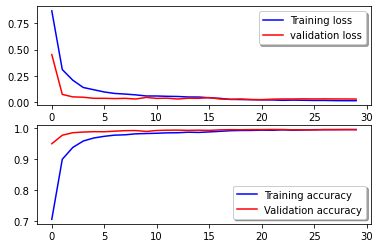

In [15]:
#Plotting loss and accuracies

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [16]:
#Predicting the results
results = model.predict(test)
#Selecting the index with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [17]:
#Daving submissions as a csv file
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv('submission.csv',index=False)

In [18]:
#Saving model
model_json = model.to_json()
with open("model.json", "w") as json_file :
    json_file.write(model_json)
model.save_weights("model.h5")